In [1]:
import matplotlib.pyplot as plt
from sunpy.map import Map
from sunpy.net import Fido, attrs as a
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patches as patches
import os
import drms

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
/Users/lilli/Library/Caches/pypoetry/virtualenvs/mhsxtrapy-_witMKZG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
jsoc_email = "lillinadol@gmail.com"

result = Fido.search(
    a.Time("2011-02-15 00:00:00", "2011-02-15 00:01:00"),
    a.Sample(1 * u.hour),
    a.jsoc.Series("hmi.sharp_cea_720s"),
    a.jsoc.PrimeKey("HARPNUM", 377),
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment("Br"),
)
print(result)

Results from 1 Provider:

1 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

         T_REC          TELESCOP  INSTRUME WAVELNTH CAR_ROT
----------------------- -------- --------- -------- -------
2011.02.15_00:00:00_TAI  SDO/HMI HMI_SIDE1   6173.0    2106




In [4]:
file = Fido.fetch(result)
sharp_map = Map(file)

2025-06-05 11:43:17 - drms - INFO: Export request pending. [id=JSOC_20250605_001256, status=2]
2025-06-05 11:43:17 - drms - INFO: Waiting for 0 seconds...
2025-06-05 11:43:18 - drms - INFO: Export request pending. [id=JSOC_20250605_001256, status=1]
2025-06-05 11:43:18 - drms - INFO: Waiting for 5 seconds...
2025-06-05 11:43:23 - drms - INFO: Export request pending. [id=JSOC_20250605_001256, status=1]
2025-06-05 11:43:23 - drms - INFO: Waiting for 5 seconds...
2025-06-05 11:43:29 - sunpy - INFO: 1 URLs found for download. Full request totaling 1MB


INFO: 1 URLs found for download. Full request totaling 1MB [sunpy.net.jsoc.jsoc]


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.48s/file]
See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
2025-06-05 11:43:30 - sunpy - WARNING: SunpyMetadataWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.


In [5]:
# Extract the active region number from metadata
ar_number = sharp_map.meta.get('HARPNUM')
print(f"Active Region Number (HARPNUM): {ar_number}")

Active Region Number (HARPNUM): 377


In [6]:
sharp_map.meta.get('NOAA_AR')


11158

In [7]:
sharp_map.meta.get('NOAA_NUM')


1

In [8]:
sharp_map.meta.get('NOAAARS')

In [9]:
path_aia171 = (
    "/Users/lilli/sunpy/data/aia.lev1.171A_2011_02_15T00_00_00.34Z.image_lev1.fits"
)

aia_image = Map(path_aia171).rotate()

In [10]:
left_corner = sharp_map.bottom_left_coord
right_corner = sharp_map.top_right_coord
aia_small = aia_image.submap(left_corner, top_right=right_corner)

In [11]:
from mhsxtrapy.field2d import Field2dData, FluxBalanceState

px_arcsec = (
    np.arctan(
        (
            sharp_map.fits_header["CDELT1"]
            * np.pi
            / 180
            * sharp_map.fits_header["RSUN_REF"]
        )
        / sharp_map.fits_header["DSUN_OBS"]
    )
    * 180
    / np.pi
    * 3600
)
py_arcsec = (
    np.arctan(
        (
            sharp_map.fits_header["CDELT2"]
            * np.pi
            / 180
            * sharp_map.fits_header["RSUN_REF"]
        )
        / sharp_map.fits_header["DSUN_OBS"]
    )
    * 180
    / np.pi
    * 3600
)

px_radians = px_arcsec / ((3600 * 360) / (2 * np.pi))
py_radians = py_arcsec / ((3600 * 360) / (2 * np.pi))

dist_Mm = sharp_map.fits_header["DSUN_OBS"] * 10**-6
px = px_radians * dist_Mm
py = py_radians * dist_Mm

ny, nx = sharp_map.data.shape
bz = sharp_map.data


xmin = 0.0
ymin = 0.0

xmax = nx * px
ymax = ny * py

x = np.arange(nx) * (xmax - xmin) / (nx - 1) - xmin
y = np.arange(ny) * (ymax - ymin) / (ny - 1) - ymin

zmin = 0.0

zmax = 40.0

# pz = np.float64(90.0 * 10**-3)
pz = max(px, py)
nz = int(np.floor(zmax / pz))
z = np.arange(nz) * (zmax - zmin) / (nz - 1) - zmin

nf = int(min(nx, ny))

sharp_data = Field2dData(
    nx,
    ny,
    nz,
    nf,
    px,
    py,
    pz,
    x,
    y,
    z,
    bz,
    flux_balance_state=FluxBalanceState.BALANCED,
)

In [12]:
from scipy.interpolate import griddata

nx = aia_small.data.shape[1]
ny = aia_small.data.shape[0]

x = np.arange(nx) * (sharp_data.x[-1] - sharp_data.x[0]) / (nx - 1) - sharp_data.x[0]
y = np.arange(ny) * (sharp_data.y[-1] - sharp_data.y[0]) / (ny - 1) - sharp_data.y[0]

xv_fine, yv_fine = np.meshgrid(sharp_data.x, sharp_data.y)
xv, yv = np.meshgrid(x, y)

print(
    yv.flatten().shape,
    xv.flatten().shape,
    yv_fine.flatten().shape,
    xv_fine.flatten().shape,
)
print(aia_small.data.flatten().shape)
print(np.column_stack((yv.flatten(), xv.flatten())).shape)


AIA_higherres = griddata(
    np.column_stack((yv.flatten(), xv.flatten())),
    aia_small.data.flatten(),
    np.column_stack((yv_fine.flatten(), xv_fine.flatten())),
    method="cubic",
).reshape(sharp_data.bz.shape)

(207350,) (207350,) (280488,) (280488,)
(207350,)
(207350, 2)


In [13]:
from mhsxtrapy.field3d import calculate_magfield, WhichSolution
from mhsxtrapy.field2d import maximal_a

In [14]:
# maximal_a(sharp_data, alpha=0.01, b=1.0)

In [15]:
sharp_extra = calculate_magfield(
    sharp_data,
    alpha=0.01,
    a=0.4,
    which_solution=WhichSolution.ASYMP,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
)

In [16]:
sharp_extra.nz

109

In [17]:
sharp_extra.y[-1]

137.3881267207871

In [18]:
sharp_extra.bz.max()

2617.67

In [19]:
from mhsxtrapy.plotting.vis import (
    plot_magnetogram_3D,
    plot_ddensity_xy,
    plot_ddensity_z,
    plot_dpressure_xy,
    plot_dpressure_z,
)

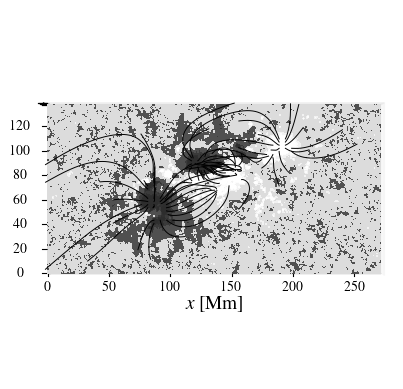

In [ ]:
plot_magnetogram_3D(sharp_extra, view="angular", footpoints="active-regions")

In [64]:
z_plot = 6

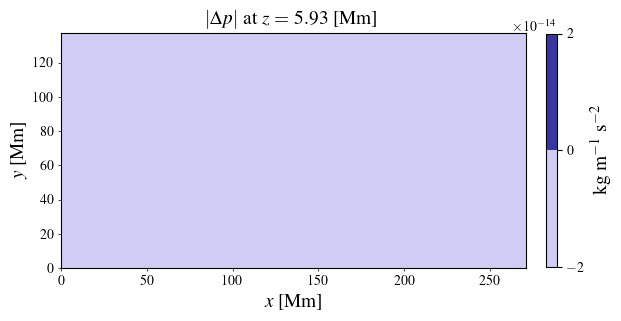

In [65]:
plot_dpressure_xy(sharp_extra, z=z_plot)

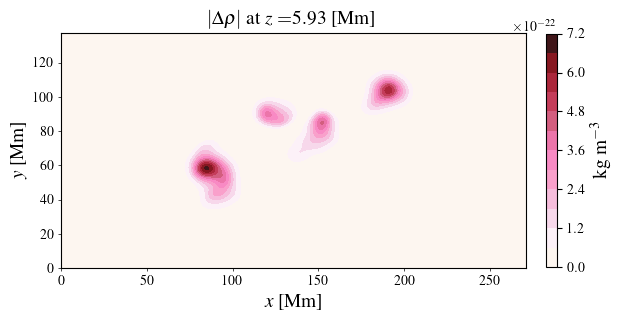

In [66]:
plot_ddensity_xy(sharp_extra, z=z_plot)

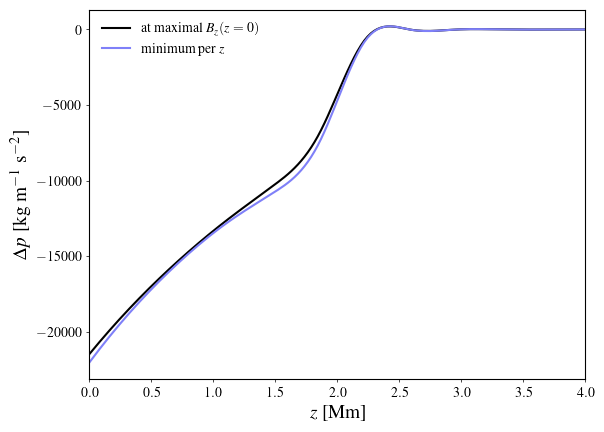

In [67]:
plot_dpressure_z(sharp_extra)

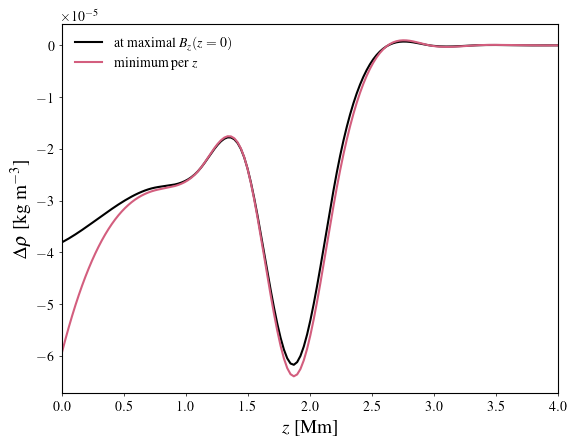

In [68]:
plot_ddensity_z(sharp_extra)